# Module import

In [1]:
from ETGEMs_function import *

# Data initialization

In [2]:
import pandas as pd
import cobra
#Get Reaction G0 from local file
reaction_g0_file='./Basic Data/reaction_g0.txt'
#Get Metabolite concentration from local file
metabolites_lnC_file = './Basic Data/metabolites_lnC.txt'
#Get Model from local file
model_file='./Basic Data/iML1515.xml'
#Get reaction kcat data from ECMpy
reaction_kcat_MW_file='./Basic Data/ID_kcat_MW_file.csv'

Concretemodel_Need_Data=Get_Concretemodel_Need_Data(reaction_g0_file,metabolites_lnC_file,model_file,reaction_kcat_MW_file)

# Solving maximum growth rate by EcoGEM (iML1515 model)

In [3]:
obj_name='BIOMASS_Ec_iML1515_core_75p37M'
obj_target='maximize'
substrate_name='EX_glc__D_e_reverse'
substrate_value=10

EcoGEM_use=EcoGEM(Concretemodel_Need_Data,obj_name,obj_target,substrate_name,substrate_value)
opt=Model_Solve(EcoGEM_use,'gurobi')
obj_no_enz_constraint=opt.obj()
obj_no_enz_constraint

0.8769972144268035

# Solving maximum growth rate by EcoECM (enzymatic constraints model)

In [4]:
obj_name='BIOMASS_Ec_iML1515_core_75p37M'
obj_target='maximize'
E_total=0.114 #eaual to e_pool （0.228）* saturation（0.5）
substrate_name='EX_glc__D_e_reverse'
substrate_value=10

EcoGEM_use=EcoECM(Concretemodel_Need_Data,obj_name,obj_target,substrate_name,substrate_value,E_total)
opt=Model_Solve(EcoGEM_use,'gurobi')
obj_enz_constraint=opt.obj()
obj_enz_constraint

0.7074061709875642

# Solving MDF value under preset growth rate
This is batch computing for two different models (EcoTCM and EcoETM).

In [5]:
import pandas as pd
import numpy as np
import datetime
from pyomo.environ import *
from pyomo.opt import SolverFactory
import pyomo.environ as pyo
from concurrent.futures import ProcessPoolExecutor, as_completed
starttime = datetime.datetime.now()
MDF_list=pd.DataFrame()
biomass_id='BIOMASS_Ec_iML1515_core_75p37M'
E_total=0.114 #eaual to e_pool （0.228）* saturation（0.5）
substrate_name='EX_glc__D_e_reverse'
substrate_value=10
biomass_value_list=np.linspace(0.3,obj_no_enz_constraint,num=500,endpoint=False,retstep=True)[0]
K_value=1249

with ProcessPoolExecutor() as executor:
    futures = {executor.submit(Max_MDF_By_model,Concretemodel_Need_Data,substrate_name,substrate_value,biomass_value,biomass_id,K_value,E_total,\
            obj_enz_constraint,obj_no_enz_constraint,'gurobi'): biomass_value for biomass_value in biomass_value_list}
    for future in as_completed(futures):
        tmp = future.result()
        for eachindex in tmp.index:
            MDF_list.loc[eachindex,'EcoTCM']=tmp.loc[eachindex,'EcoTCM'] 
            MDF_list.loc[eachindex,'EcoETM']=tmp.loc[eachindex,'EcoETM']

endtime = datetime.datetime.now()
print (endtime - starttime)
MDF_list.to_csv('./Analysis Result/MDF_list500.csv', sep=',', header=True, index=True,mode='w')

0:18:24.531070


# Results output

In [6]:
import pandas as pd
MDF_list=pd.read_csv('./Analysis Result/MDF_list500.csv',index_col=0)
MDF_list=MDF_list.sort_index(ascending=True) 
MDF_list.head(10)

,EcoTCM,EcoETM
0.300000,2.667088,2.667088
0.301154,2.667088,2.667088
0.302308,2.667088,2.667088
0.303462,2.667088,2.667088
0.304616,2.667088,2.667088
0.305770,2.667088,2.667088
0.306924,2.667088,2.667088
0.308078,2.667088,2.667088
0.309232,2.667088,2.667088
0.310386,2.667088,2.667088


# Based on above results, draw a outline picture.

/media/jupyter/Anaconda/anaconda3/envs/ETGEMs/lib/python3.5/site-packages/matplotlib/font_manager.py:1241 UserWarning: findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


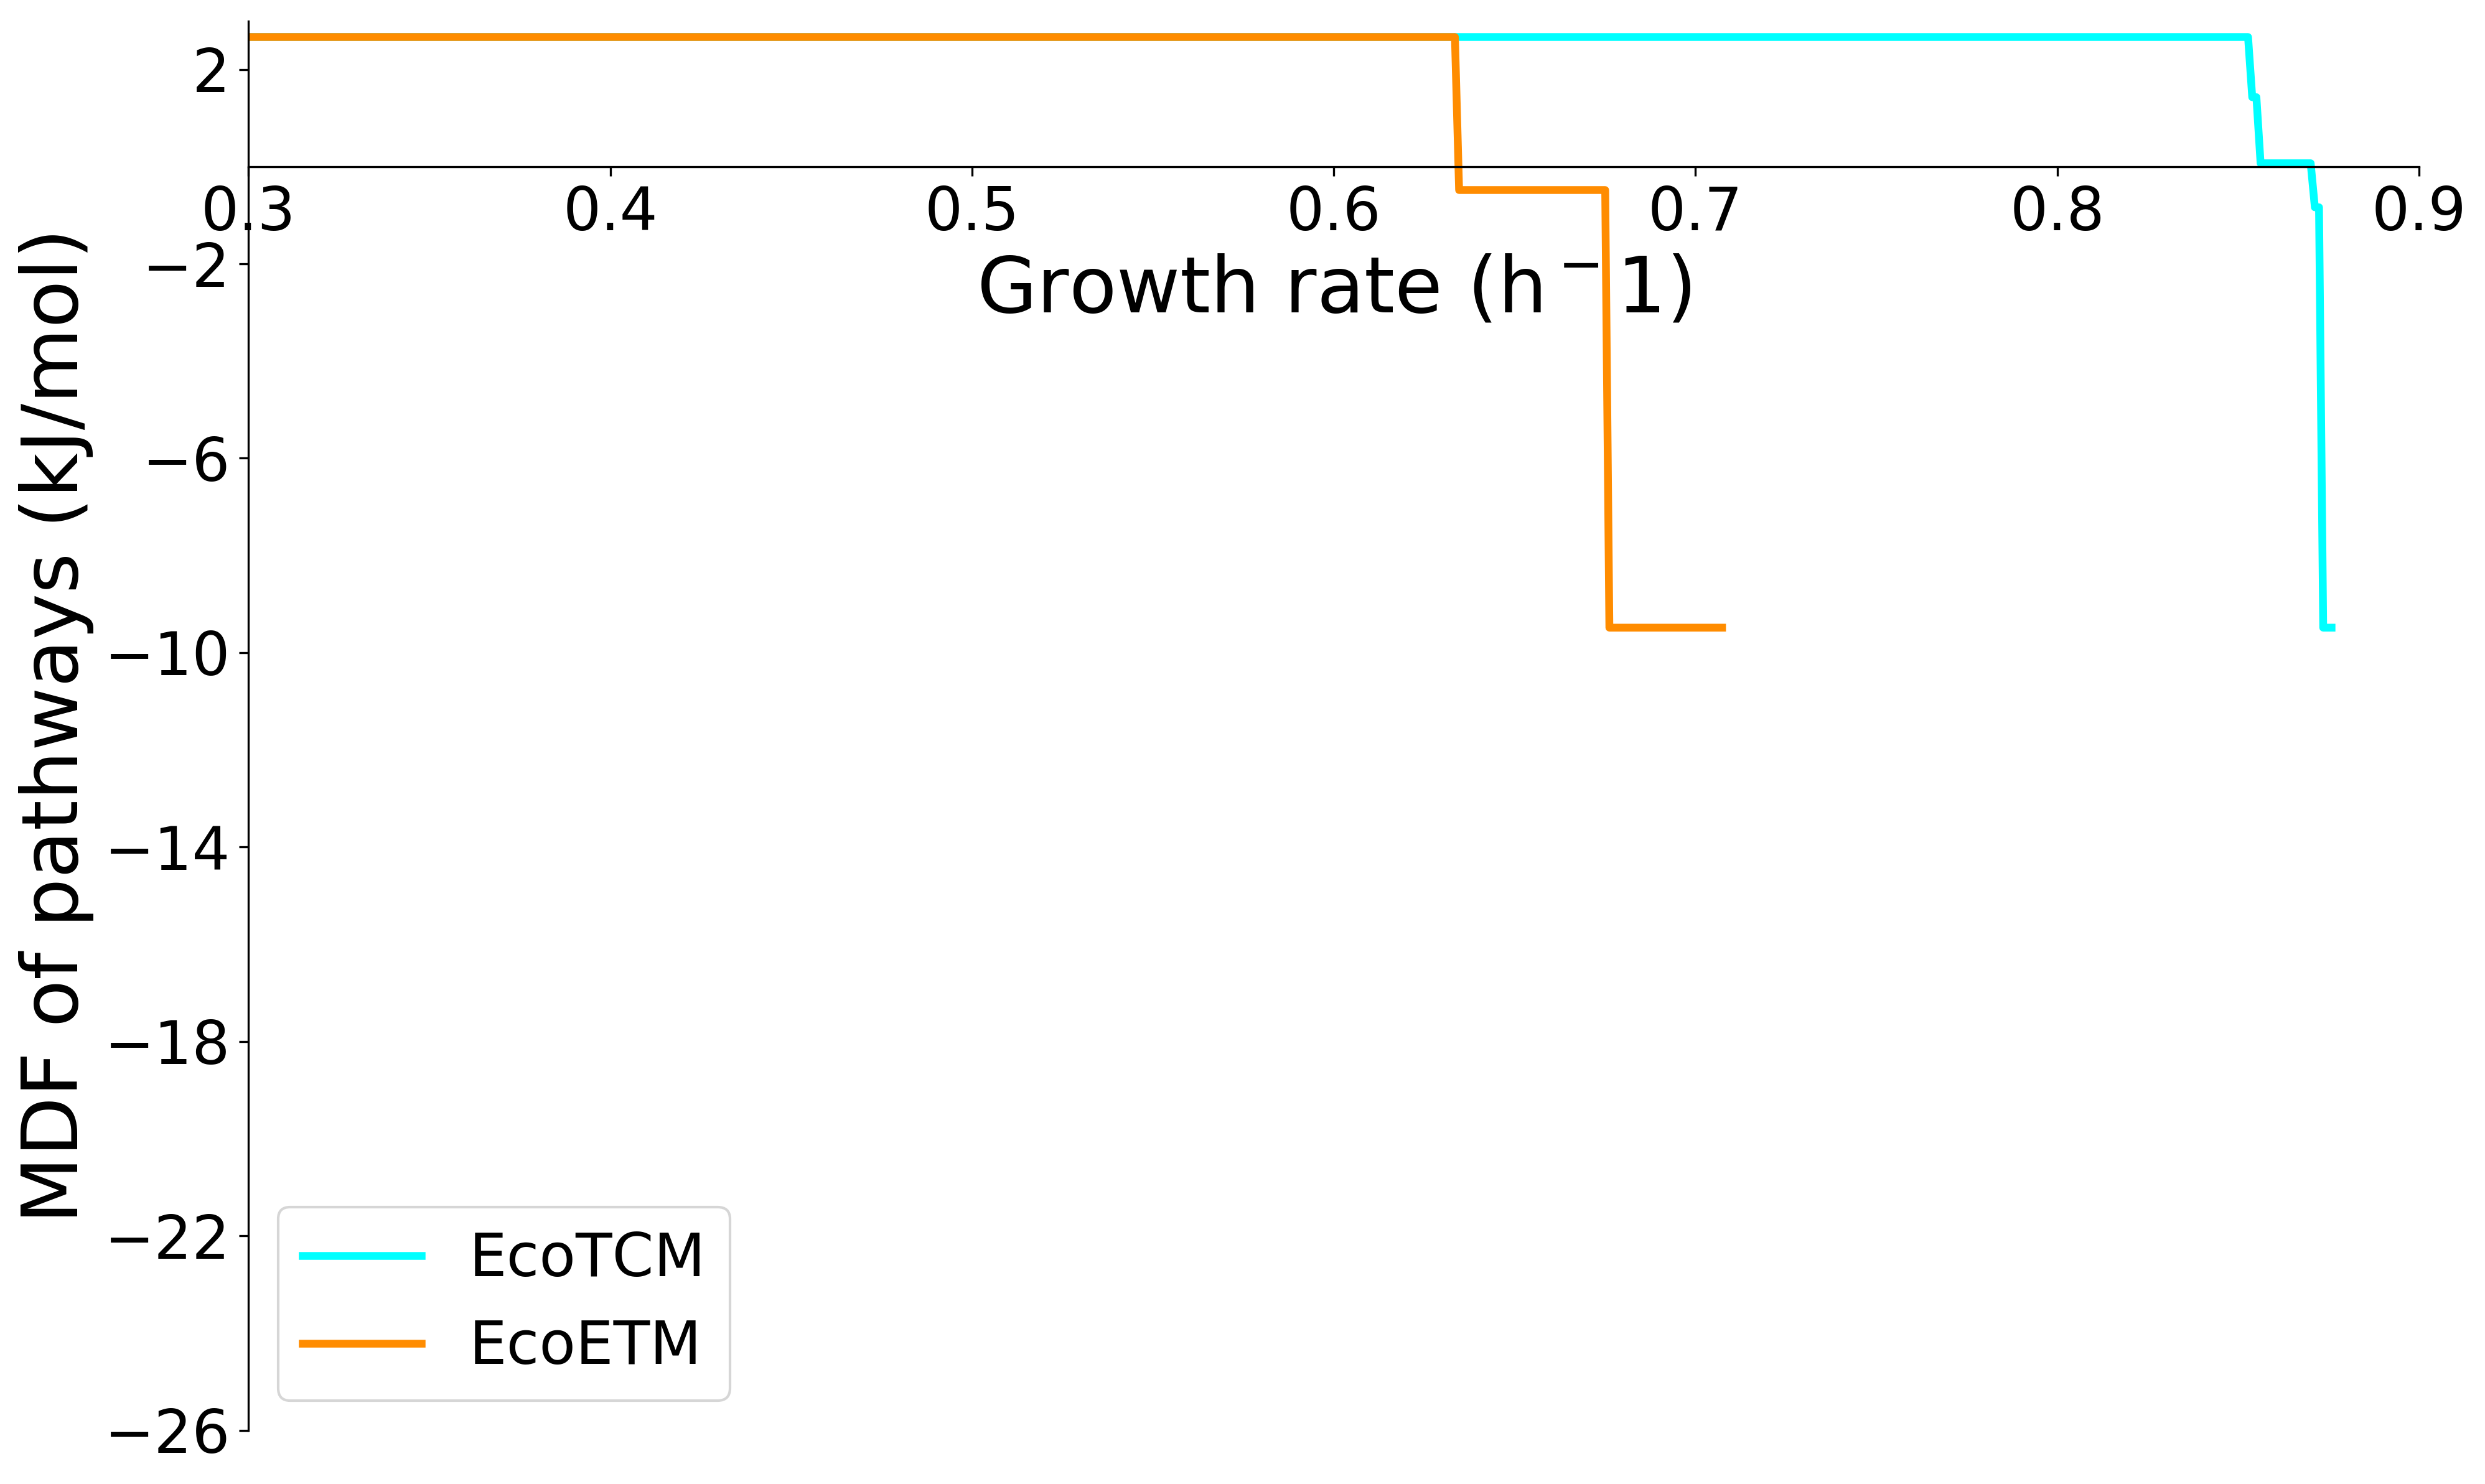

In [7]:
Draw_MDF_By_Growth_rate(MDF_list)

# Find the exact turning point
The more accurate turning point can be found by increasing the calculation numbers (reducing the step size of specific intervals).

In [8]:
import pandas as pd
import numpy as np
import datetime
from pyomo.environ import *
from pyomo.opt import SolverFactory
import pyomo.environ as pyo
from concurrent.futures import ProcessPoolExecutor, as_completed
starttime = datetime.datetime.now()
MDF_list=pd.DataFrame()
biomass_id='BIOMASS_Ec_iML1515_core_75p37M'
E_total=0.114 #eaual to e_pool （0.228）* saturation（0.5）
substrate_name='EX_glc__D_e_reverse'
substrate_value=10

tmp1=list(np.linspace(0.3,0.6,num=100,endpoint=False,retstep=True)[0])
tmp2=list(np.linspace(0.6,0.64,num=100,endpoint=False,retstep=True)[0])
tmp3=list(np.linspace(0.64,0.707,num=200,endpoint=False,retstep=True)[0])
tmp4=list(np.linspace(0.707,0.708,num=1000,endpoint=False,retstep=True)[0])
tmp5=list(np.linspace(0.708,0.85,num=100,endpoint=False,retstep=True)[0])
tmp6=list(np.linspace(0.85,0.876,num=500,endpoint=False,retstep=True)[0])
tmp7=list(np.linspace(0.876,0.878,num=1000,endpoint=False,retstep=True)[0])
biomass_value_list=tmp1+tmp2+tmp3+tmp4+tmp5+tmp6+tmp7
K_value=1249

with ProcessPoolExecutor() as executor:
    futures = {executor.submit(Max_MDF_By_model,Concretemodel_Need_Data,substrate_name,substrate_value,biomass_value,biomass_id,K_value,E_total,\
                        obj_enz_constraint,obj_no_enz_constraint,'gurobi'):biomass_value for biomass_value in biomass_value_list}
    for future in as_completed(futures):
        tmp = future.result()
        for eachindex in tmp.index:
            MDF_list.loc[eachindex,'EcoTCM']=tmp.loc[eachindex,'EcoTCM']   
            MDF_list.loc[eachindex,'EcoETM']=tmp.loc[eachindex,'EcoETM']

endtime = datetime.datetime.now()
print (endtime - starttime)
MDF_list.to_csv('./Analysis Result/MDF_list_select.csv', sep=',', header=True, index=True,mode='w')

1:19:02.316690


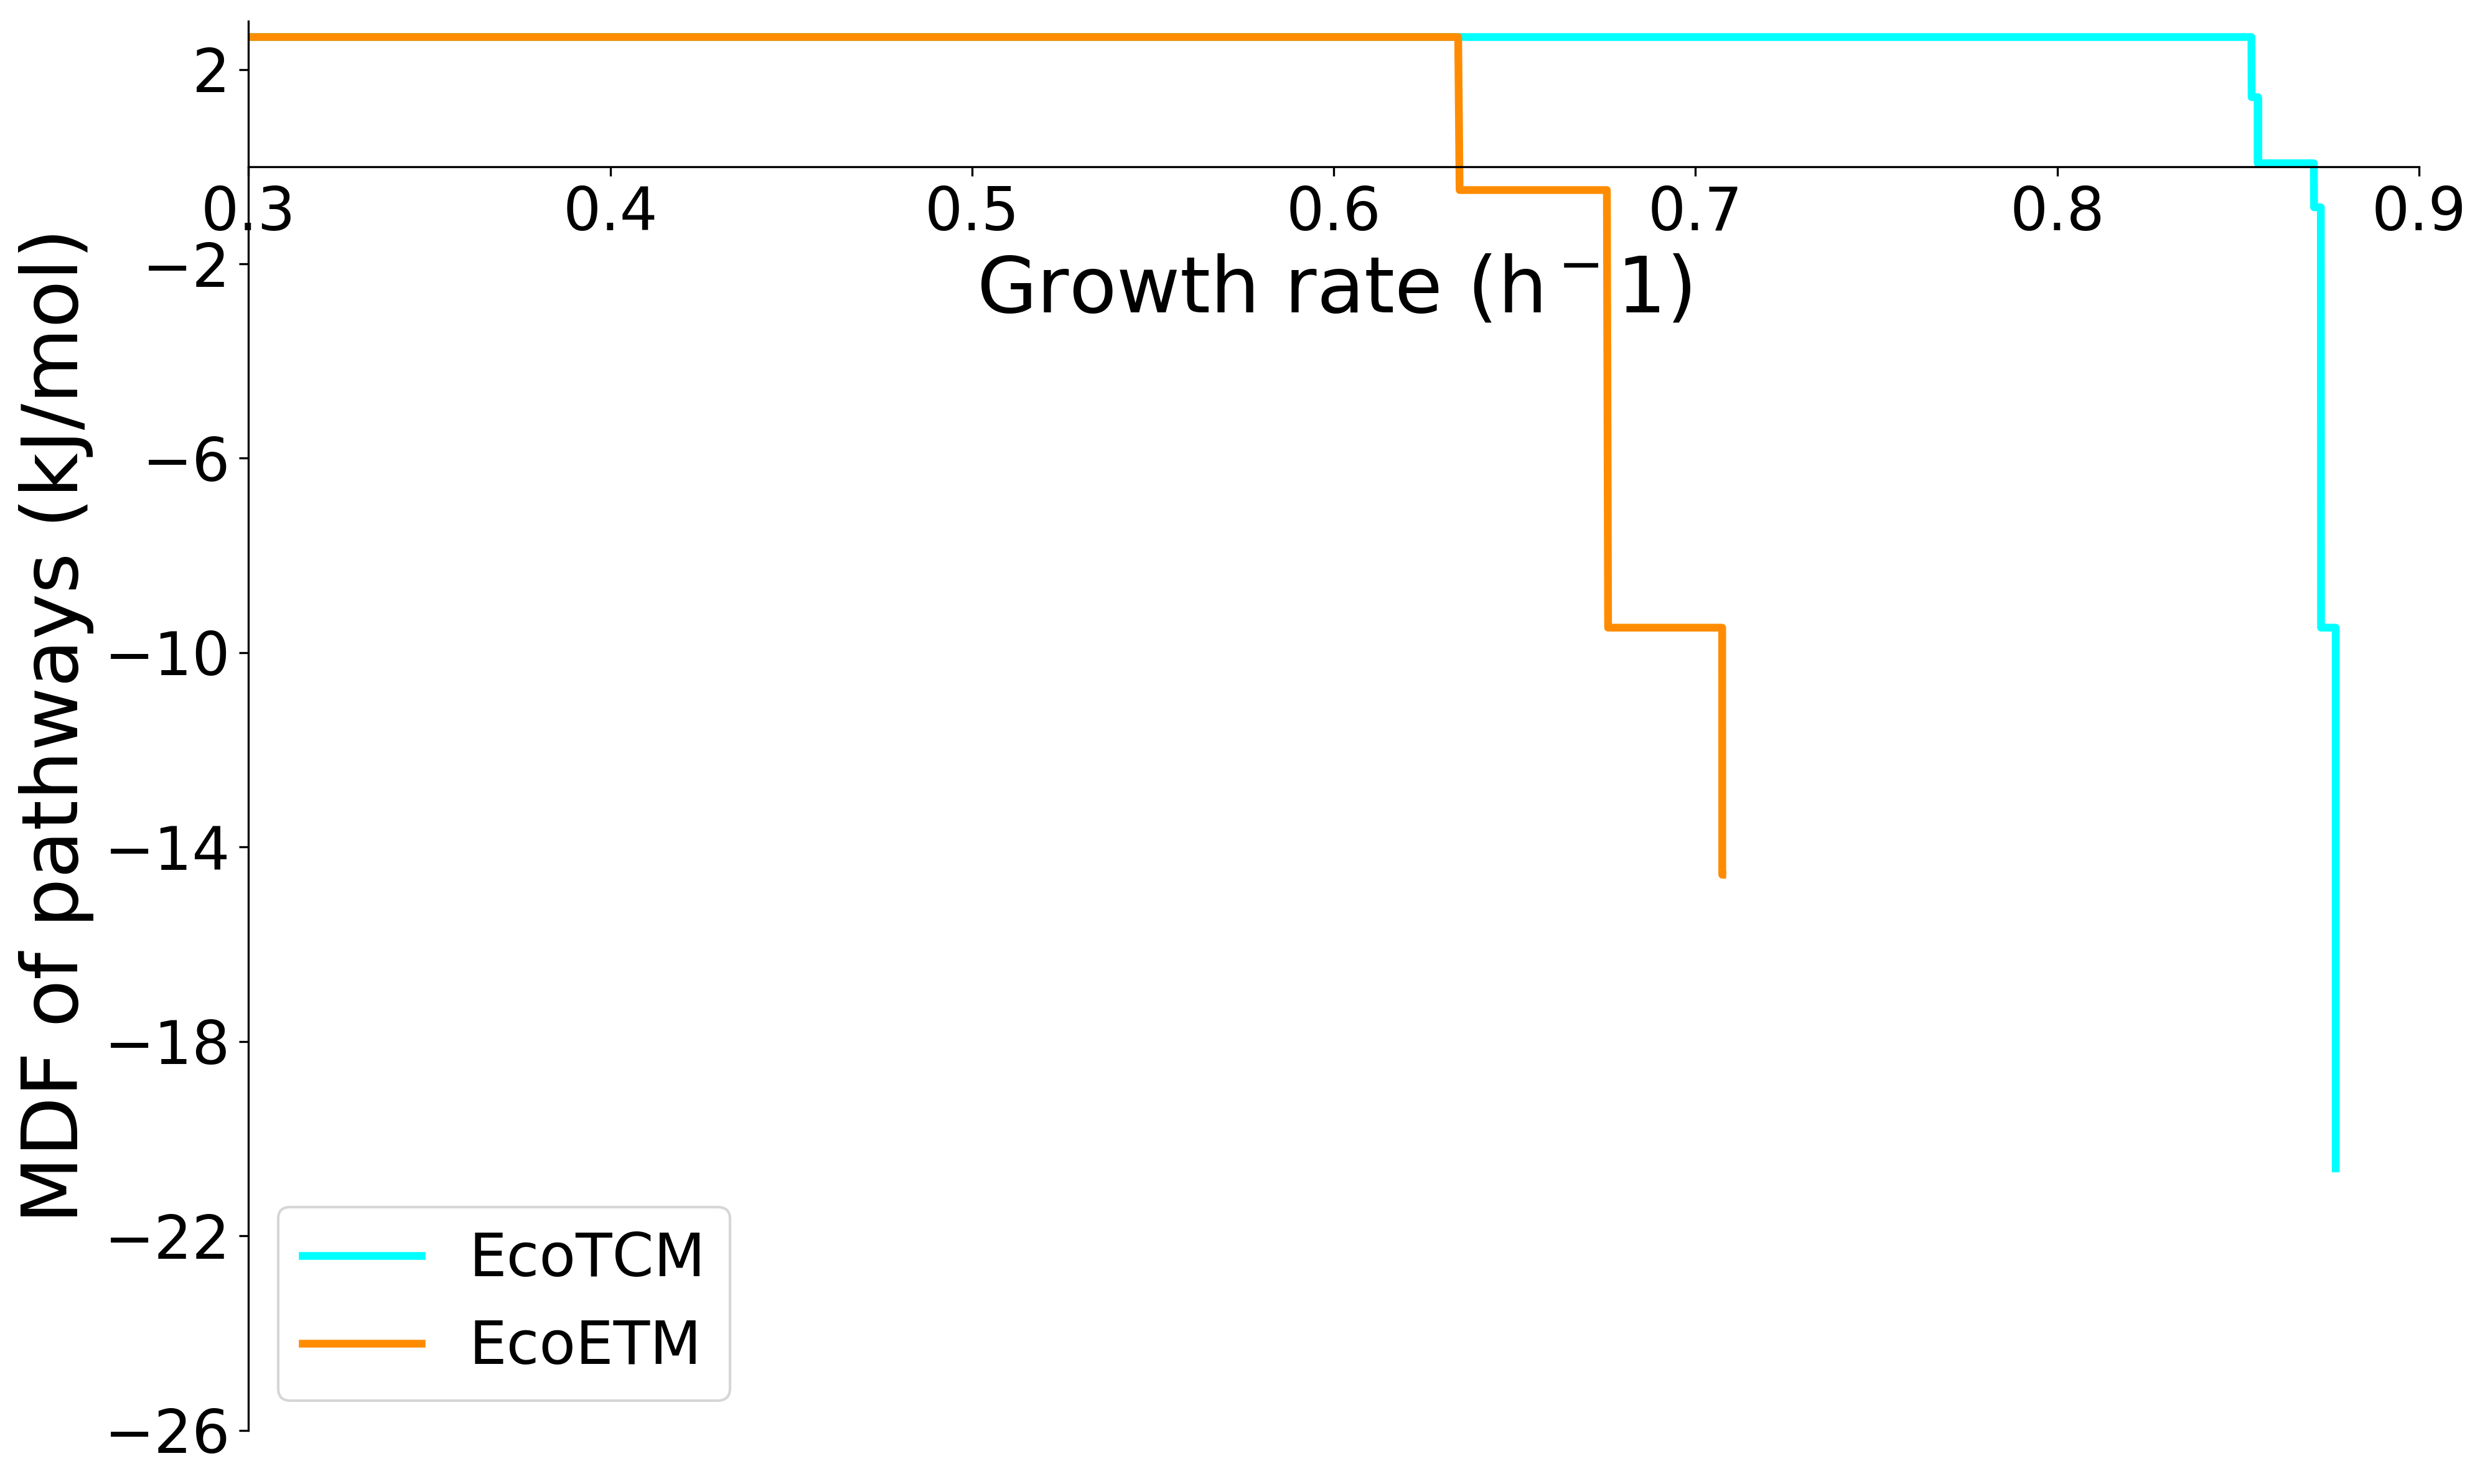

In [9]:
import pandas as pd
MDF_list=pd.read_csv('./Analysis Result/MDF_list_select.csv',index_col=0)
MDF_list=MDF_list.sort_index(ascending=True) 
Draw_MDF_By_Growth_rate(MDF_list)